# 從 google drive 下載資料集
1. 使用training_data_version2

In [ ]:
# ame
!gdown "1RPecIBIFfY5GL9g3Sz6TW3JobsBee7lC" --output ame.zip
!unzip ame.zip -d ame_data

# calli
!gdown "1IepVqUIr0GJuTHHosRH_-iEH_-CWpGSO" --output calli.zip
!unzip calli.zip -d calli_data

# gura
!gdown "1Ht64ePfx_PjQgblGuJZbo48FDTrWPT2z" --output gura.zip
!unzip gura.zip -d gura_data

# ina
!gdown "1fOKdNLa23R5InTIZpXHIxxBKInwXc3a7" --output ina.zip
!unzip ina.zip -d ina_data

# kiara
!gdown "1Rsh0AZC5VG-NbFs0DBpa8IDuQMEVeWk2" --output kiara.zip
!unzip kiara.zip -d kiara_data

# kronii
!gdown "1rSxfjTOlR10IdynBfGFlmOP2SZOj7XnC" --output kronii.zip
!unzip kronii.zip -d kronii_data

# resize 並放入 dataframe

In [ ]:
# import
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

In [ ]:
import pandas as pd


df = pd.DataFrame(columns=[ "path", "target" ])

for path in glob.glob("/content/ame_data/ame_*.jpg"):
    s = pd.Series( [path, 0], index=[ "path", "target" ])
    df = df.append(s, ignore_index=True)

for path in glob.glob("/content/calli_data/calli_*.jpg"):
    s = pd.Series( [path, 1], index=[ "path", "target" ])
    df = df.append(s, ignore_index=True)

for path in glob.glob("/content/gura_data/gura_*.jpg"):
    s = pd.Series( [path, 2], index=[ "path", "target" ])
    df = df.append(s, ignore_index=True)

for path in glob.glob("/content/ina_data/ina_*.jpg"):
    s = pd.Series( [path, 3], index=[ "path", "target" ])
    df = df.append(s, ignore_index=True)

for path in glob.glob("/content/kiara_data/kiara_*.jpg"):
    s = pd.Series( [path, 4], index=[ "path", "target" ])
    df = df.append(s, ignore_index=True)

for path in glob.glob("/content/kronii_data/kronii_*.jpg"):
    s = pd.Series( [path, 5], index=[ "path", "target" ])
    df = df.append(s, ignore_index=True)

/content/kiara_data/kiara_202.jpg


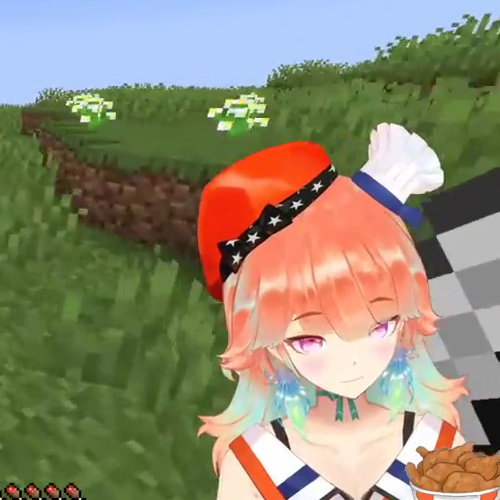

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
import random


random_index = random.randint(0,6356)

print(df["path"][random_index])
load_img(df["path"][random_index])

# 建立模型

In [ ]:
# 擷取 VGG16 的 CNN
from tensorflow.keras.applications.vgg16 import VGG16 


vgg = VGG16( include_top=False, input_shape=(224,224,3) )
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization


for layer in vgg.layers:
    layer.trainable=False

x = BatchNormalization()(vgg.output)

x = Flatten()(x) 
x = Dense(units=2048, activation="relu")(x)
x = Dense(units=256, activation="relu")(x)
x = Dense(units=64, activation="relu")(x)
x = Dense(units=6, activation="softmax")(x)

cnn = Model(inputs=vgg.input, outputs=x)
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
cnn.compile( loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np


# to_categorical
y_categorical = to_categorical(df["target"])

x_train, x_test, y_train, y_test = train_test_split( np.array(df["path"]),
                               np.array(y_categorical),
                               test_size=0.1)

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


batch_size = 100

for i in range(5):
    idx = np.random.randint( 0, x_train.shape[0], batch_size )

    imglist = []

    for fn in x_train[idx]:
        img = load_img( fn, target_size=(224, 224) )
        img = preprocess_input( np.array(img) )
        imglist.append(img)

    x = np.array(imglist)
    y = y_train[idx]
    result = cnn.train_on_batch(x, y) # train_on_batch 會輸出: loss值, 正確率
    print("-----Times", i, "-----")
    print(result)

-----Times 0 -----
[2.0094964504241943, 0.18000000715255737]
-----Times 1 -----
[1.3438949584960938, 0.7300000190734863]
-----Times 2 -----
[0.11787199229001999, 0.949999988079071]
-----Times 3 -----
[0.012882054783403873, 1.0]
-----Times 4 -----
[0.1354106217622757, 0.9599999785423279]


In [ ]:
batch_size = 100

idx = np.random.randint( 0, x_test.shape[0], batch_size )

imglist = []

for fn in x_test[idx]:
    img = load_img( fn, target_size=(224, 224) )
    img = preprocess_input( np.array(img) )
    imglist.append(img)

x = np.array(imglist)
y = y_test[idx]
cnn.evaluate(x, y)

4/4 [==============================] - 6s 416ms/step - loss: 0.0398 - accuracy: 0.9900


[0.03977879881858826, 0.9900000095367432]

In [ ]:
predicted_vtuber = cnn.predict(x).argmax(axis=-1)
print(predicted_vtuber)
actual_vtuber = np.array(y).argmax(axis=-1)
print(actual_vtuber)

4/4 [==============================] - 1s 141ms/step
[4 3 4 0 2 2 4 2 5 4 1 1 1 5 2 2 1 2 5 3 1 4 4 2 4 2 4 2 5 0 5 5 0 3 3 2 2
 3 4 1 0 0 3 5 1 2 2 5 0 3 1 1 4 3 3 2 0 0 5 5 3 0 1 3 4 1 2 0 1 3 1 3 5 0
 5 3 0 0 1 1 2 3 2 3 3 2 3 1 5 0 3 5 3 5 2 3 4 2 4 3]
[4 3 4 0 2 2 4 2 5 4 1 1 1 5 2 2 1 2 5 3 1 4 4 2 4 2 4 2 5 0 5 5 0 3 3 2 2
 3 4 1 0 0 3 5 1 2 2 0 0 3 1 1 4 3 3 2 0 0 5 5 3 0 1 3 4 1 2 0 1 3 1 3 5 0
 5 3 0 0 1 1 2 3 2 3 3 2 3 1 5 0 3 5 3 5 2 3 4 2 4 3]


In [ ]:
plt.figure(figsize=(20,25))

for (index, img) in enumerate(x):
    plt.subplot(10, 21, index+1)
    plt.axis("off")
    plt.imshow(img)

In [ ]:
from tensorflow.keras.models import load_model


cnn.save('transfer_learning_VGG16.h5')

# 真實照片測試

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np


model = load_model("/content/transfer_learning_VGG16.h5")

img_path = '/content/kronii_79.jpg'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = preprocess_input(x)
x = np.expand_dims(x, axis=0)

preds = model.predict(x)
idx = np.argsort(preds)[0]
top_idxs = idx[-2:]

vtuber_list = ["ame", "calli", "gura", "ina", "kiara", "kronii"]

print(f"預測第一順位: {vtuber_list[top_idxs[0]]}")
print(f"預測第二順位: {vtuber_list[top_idxs[1]]}")

1/1 [==============================] - 0s 154ms/step
預測第一順位: kiara
預測第二順位: kronii


In [ ]:
# 訓練資料 VS 真實標的